In [1]:
from datasets import load_dataset, Image
from torch.utils.data import DataLoader
from mit_semseg.models.resnet import resnet50
from mit_semseg.models import ModelBuilder, SegmentationModule 
import PIL
import torch
import torch.nn as nn
from torch.optim import AdamW
from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np
import evaluate
from torchvision import transforms
import matplotlib.pyplot as plt

2023-10-23 07:22:37.412624: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 07:22:37.412670: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 07:22:37.412712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Training

In [2]:
ade20k_train = load_dataset("scene_parse_150",split='train')

In [3]:
def prep_dataset(sample):
    img = sample['image']
    label = sample['annotation']
    sample['width'] = img.width
    sample['height'] = img.height

    if (img.mode == 'L') | (img.mode == 'CMYK') | (img.mode == 'RGBA'):
        rgbimg = PIL.Image.new("RGB", img.size)
        rgbimg.paste(img)
        img = rgbimg

    img = img.resize((256,256),resample=PIL.Image.Resampling.LANCZOS)
    label = label.resize((32,32),resample=PIL.Image.Resampling.NEAREST)
    
    sample['image'] = Image().encode_example(img)
    sample['annotation'] = Image().encode_example(label)
    return sample

In [4]:
train_dataset = ade20k_train.map(prep_dataset).with_format("torch")

In [5]:
encoder = ModelBuilder().build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='').cuda()
decoder = ModelBuilder().build_decoder(
    arch='ppm',
    fc_dim=2048,
    num_class=150,
    weights='',
    use_softmax=False).cuda()
crit = nn.NLLLoss(ignore_index=-1)
optimizer = AdamW(decoder.parameters(), lr=1e-3)

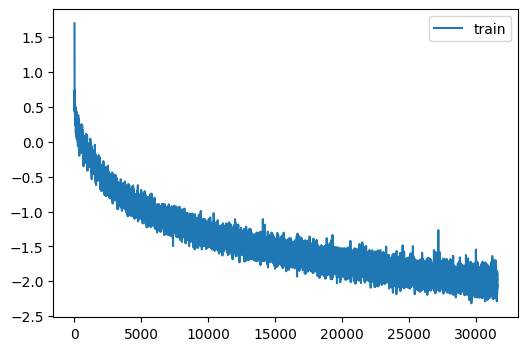

In [6]:
log_train_loss = []
epochs = 100
mb = master_bar(range(epochs))
for epoch in mb:
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    for batch in progress_bar(train_dataloader,parent=mb):
        optimizer.zero_grad()
        x = batch['image'].to(torch.float32).permute((0,3,1,2))
        x = (x/255).cuda()
        y = batch['annotation'].to(torch.int64) - 1   
        y = y.cuda()
        ŷ = decoder(encoder(x))
        loss = crit(ŷ,y)
        loss.backward()
        optimizer.step()
        log_train_loss.append(np.log(loss.detach().cpu().item()))
    mb.update_graph([[range(len(log_train_loss)),log_train_loss]])
    torch.save(decoder.state_dict(), f"decoder_weights_epoch_{epoch}.pth")

# Inference

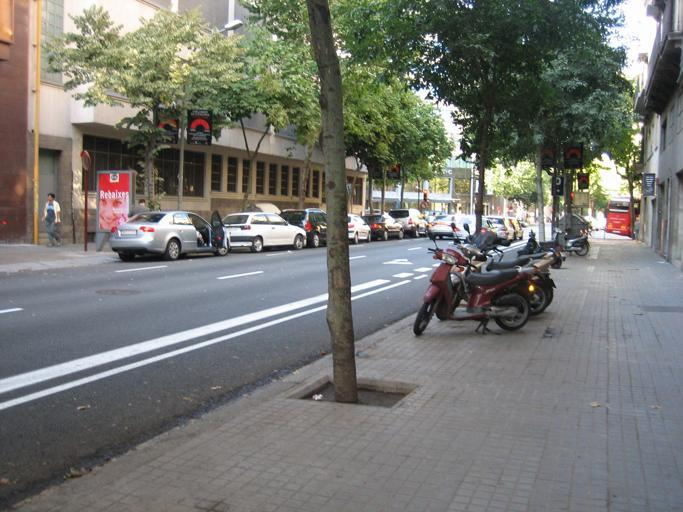

In [2]:
ade20k_valid = load_dataset("scene_parse_150",split='validation')
ade20k_valid[0]['image']

In [3]:
ade20k_valid = ade20k_valid.with_format("torch")

In [4]:
encoder = ModelBuilder().build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='').cuda()
decoder = ModelBuilder().build_decoder(
    arch='ppm',
    fc_dim=2048,
    num_class=150,
    weights='decoder_weights_epoch_99.pth',
    use_softmax=False).cuda()

Loading weights for net_decoder


In [7]:
%%time
mean_iou = evaluate.load("mean_iou")
x = []
y = []
for sample in ade20k_valid:
    ground_truth = sample['annotation']
    img = sample['image'].to(torch.float32).permute(2,0,1).unsqueeze(0).cuda()
    img = transforms.Resize((256,256),antialias=True)(img)
    img = torch.cat([img,img])
    z = encoder(img)
    logits = decoder(z)
    logits = logits[0,:,:,:].unsqueeze(0)
    predictions = logits.argmax(dim=1)[0].detach().cpu()
    resize = transforms.Resize(
        (ground_truth.shape[0],ground_truth.shape[1]),
        antialias=True
    )
    predictions = resize(
        predictions.unsqueeze(0).unsqueeze(0)
    )[0][0]
    
    x.append(np.array(ground_truth))
    y.append(np.array(predictions))

CPU times: user 1min 1s, sys: 6.38 s, total: 1min 8s
Wall time: 44.1 s


In [10]:
%%time
mean_iou.compute(
    predictions=y,
    references=x,
    num_labels=150,
    ignore_index=255,
    reduce_labels=True
)['mean_iou']

CPU times: user 29min 19s, sys: 38.9 s, total: 29min 58s
Wall time: 29min 59s


0.023835101076332903

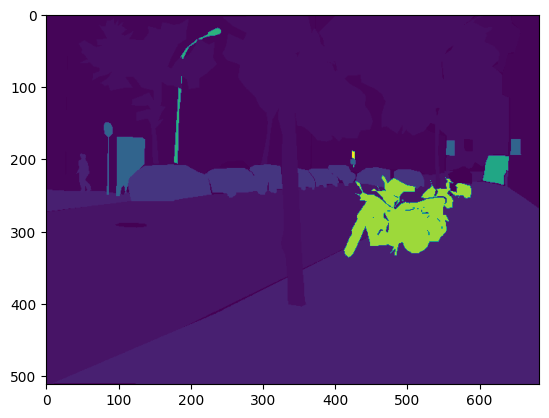

In [8]:
plt.imshow(ade20k_valid[0]['annotation'])

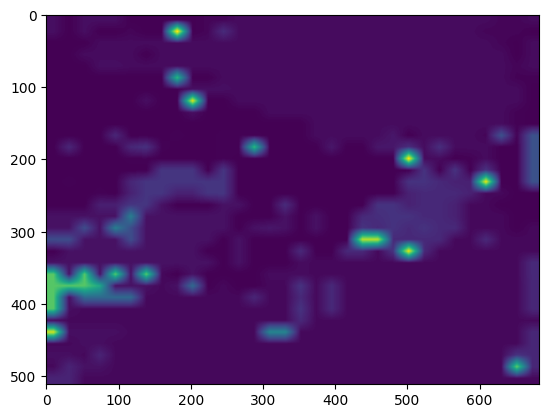

In [9]:
plt.imshow(y[0])